# Single Elders Home Monitoring : PCA filtering

In [1]:
 ## Imports

In [2]:
# needed for pyspark windows installs
import findspark
findspark.init()

import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from scipy.ndimage import median_filter
import plotly
import plotly.express as px
import plotly.offline as py
import sklearn
from sklearn.decomposition import PCA as SklearnPCA

# Enable offline mode
import plotly.io as pio
pio.renderers.keys()
pio.renderers.default = 'jupyterlab' 

from pyspark.conf import SparkConf
from pyspark.sql import SparkSession 

spark = (SparkSession.
     builder.
     master('local[*]'). # leave out for cluster mode
     appName('single-elders-monitoring').
     config(conf = SparkConf()).
     getOrCreate())

from pyspark.ml.feature import PCA
from pyspark.sql.functions import col
from pyspark.sql.functions import asc
from pyspark.sql.window import Window
from pyspark.sql import functions as F
from pyspark.sql.types import FloatType, IntegerType
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA
from pyspark.ml.functions import vector_to_array
from pyspark.ml.feature import StandardScaler
from pyspark.sql.functions import col, concat, dayofmonth, hour, month, year
from pyspark.sql.functions import mean
from pyspark.sql.functions import lit



Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/06/07 08:04:13 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
## Flags

In [4]:
COMPUTE_EVENTS = False

## Import datasets

In [5]:
no_occupants_url = './data/data_ref_until_2020-02-13.csv'
no_occupants_df = spark.read.csv(no_occupants_url, header=True,inferSchema=True) \
                                .where("('2020-01-27' <= timestamp) AND (timestamp <='2020-02-04')")
no_occupants_df.show()
no_occupants_df.select(F.min(no_occupants_df.timestamp).alias('start date'),F.max(no_occupants_df.timestamp).alias('end date')).show()
print('The dataset with no occupants has {} rows and {} features.'.format(no_occupants_df.count(), len(no_occupants_df.columns)))

+--------------------+-----------+--------+-------------+-------------+-----+-----+-----+-----+-------+
|           timestamp|temperature|humidity|CO2CosIRValue|CO2MG811Value| MOX1| MOX2| MOX3| MOX4|COValue|
+--------------------+-----------+--------+-------------+-------------+-----+-----+-----+-----+-------+
|2020-01-27 00:00:...|      19.93|    56.1|         77.0|        503.0|533.0|710.0|669.0|616.0|  113.0|
|2020-01-27 00:00:...|      19.92|   56.17|         77.0|        503.0|533.0|710.0|669.0|615.0|  113.0|
|2020-01-27 00:00:...|      19.88|    56.2|         78.0|        503.0|532.0|709.0|668.0|615.0|  113.0|
|2020-01-27 00:01:...|      19.85|    56.3|         78.0|        504.0|532.0|709.0|668.0|615.0|  114.0|
|2020-01-27 00:01:...|       19.8|   56.63|         78.0|        504.0|532.0|709.0|668.0|615.0|  114.0|
|2020-01-27 00:01:...|      19.72|   56.71|         78.0|        504.0|532.0|709.0|668.0|615.0|  114.0|
|2020-01-27 00:02:...|      19.68|   56.75|         78.0|       

In [6]:
occupants_url = './data/database_gas.csv'
occupants_df = spark.read.csv(occupants_url, header=True,inferSchema=True) \
                            .where("timestamp < '2020-01-25'")
occupants_df.show()
occupants_df.select(F.min(occupants_df.timestamp).alias('start date'),F.max(occupants_df.timestamp).alias('end date')).show()
print('The dataset with occupants has {} rows and {} features.'.format(occupants_df.count(), len(occupants_df.columns)))

+--------------------+-----------+--------+-------------+-------------+-----+-----+-----+-----+-------+
|           timestamp|temperature|humidity|CO2CosIRValue|CO2MG811Value| MOX1| MOX2| MOX3| MOX4|COValue|
+--------------------+-----------+--------+-------------+-------------+-----+-----+-----+-----+-------+
|2019-11-06 10:37:...|      19.48|   54.86|        128.0|        563.0|476.0|731.0|649.0|565.0|  128.0|
|2019-11-06 10:37:...|      19.59|   54.23|        129.0|        563.0|477.0|731.0|649.0|565.0|  125.0|
|2019-11-06 10:37:...|      19.63|   54.05|        128.0|        566.0|478.0|732.0|649.0|565.0|  125.0|
|2019-11-06 10:38:...|      19.64|   53.74|        128.0|        566.0|478.0|732.0|649.0|565.0|  125.0|
|2019-11-06 10:38:...|      19.67|   53.53|        128.0|        569.0|480.0|732.0|650.0|565.0|  125.0|
|2019-11-06 10:38:...|      19.67|   53.53|        126.0|        570.0|481.0|733.0|650.0|565.0|  123.0|
|2019-11-06 10:39:...|      19.67|   53.53|        128.0|       

## Sliding window median filter

In [7]:
window_size=11

# defining window
windowSpec = Window.partitionBy("day_month_year").orderBy(asc("timestamp")).rowsBetween(-window_size//2, window_size//2) #Note: we can divide partition by hours to speed up computation

# Spark doesn't have a built-in implementation of median
rolling_median_udf = F.udf(lambda x: float(np.median(x)), FloatType())

cols_to_process = no_occupants_df.columns.copy()
cols_to_process.remove('timestamp')

conversion_dict = {column: rolling_median_udf(F.collect_list(column).over(windowSpec)) for column in cols_to_process}

# filtering dataset of when no occupant is in the house
no_occupants_filtered_df = no_occupants_df.withColumn("day_month_year", concat(dayofmonth(col("timestamp")), month(col("timestamp")), year(col("timestamp"))))
no_occupants_filtered_df = no_occupants_filtered_df.withColumns(conversion_dict)
no_occupants_filtered_df.sort('timestamp').show()
print('The filtered dataset with no occupants has {} rows and {} features.'.format(no_occupants_filtered_df.count(), len(no_occupants_filtered_df.columns)))

# filtering dataset of when occupant is in the house
occupants_filtered_df = occupants_df.withColumn("day_month_year", concat(dayofmonth(col("timestamp")), month(col("timestamp")), year(col("timestamp"))))
occupants_filtered_df = occupants_filtered_df.withColumns(conversion_dict)
occupants_filtered_df.sort('timestamp').show()
print('The filtered dataset with occupants has {} rows and {} features.'.format(occupants_filtered_df.count(), len(occupants_filtered_df.columns)))


+--------------------+-----------+--------+-------------+-------------+-----+-----+-----+-----+-------+--------------+
|           timestamp|temperature|humidity|CO2CosIRValue|CO2MG811Value| MOX1| MOX2| MOX3| MOX4|COValue|day_month_year|
+--------------------+-----------+--------+-------------+-------------+-----+-----+-----+-----+-------+--------------+
|2020-01-27 00:00:...|     19.865|   56.25|         78.0|        503.5|532.0|709.0|668.0|615.0|  113.5|       2712020|
|2020-01-27 00:00:...|      19.85|    56.3|         78.0|        504.0|532.0|709.0|668.0|615.0|  114.0|       2712020|
|2020-01-27 00:00:...|     19.825|  56.465|         78.0|        504.0|532.0|709.0|668.0|615.0|  114.0|       2712020|
|2020-01-27 00:01:...|       19.8|   56.63|         78.0|        504.0|532.0|709.0|668.0|615.0|  114.0|       2712020|
|2020-01-27 00:01:...|      19.76|   56.67|         78.0|        504.0|532.0|709.0|668.0|615.0|  114.0|       2712020|
|2020-01-27 00:01:...|      19.72|   56.71|     

+--------------------+-----------+--------+-------------+-------------+-----+-----+-----+-----+-------+--------------+
|           timestamp|temperature|humidity|CO2CosIRValue|CO2MG811Value| MOX1| MOX2| MOX3| MOX4|COValue|day_month_year|
+--------------------+-----------+--------+-------------+-------------+-----+-----+-----+-----+-------+--------------+
|2019-11-06 10:37:...|     19.635|  53.895|        128.0|        566.0|478.0|732.0|649.0|565.0|  125.0|       6112019|
|2019-11-06 10:37:...|      19.64|   53.74|        128.0|        566.0|478.0|732.0|649.0|565.0|  125.0|       6112019|
|2019-11-06 10:37:...|     19.655|  53.635|        128.0|        567.5|479.0|732.0|649.5|565.0|  125.0|       6112019|
|2019-11-06 10:38:...|      19.67|   53.53|        128.0|        569.0|480.0|732.0|650.0|565.0|  125.0|       6112019|
|2019-11-06 10:38:...|      19.67|   53.53|        128.0|        569.5|480.5|732.0|650.0|565.0|  124.0|       6112019|
|2019-11-06 10:38:...|      19.67|   53.53|     

#### Sensors signals after median filter (plot)

In [8]:
visual_filtered_df = occupants_filtered_df.where("timestamp > '2019-11-11' AND timestamp < '2019-11-12'")

# for some reason, sensor signals are divided by this value by the authors (?)
V_divider = 210
columns_to_normalize = ['CO2CosIRValue','CO2MG811Value','MOX1','MOX2','MOX3','MOX4','COValue']
columns_to_keep = ['timestamp','temperature', 'humidity']
  
visual_filtered_df = visual_filtered_df.select([col(c) for c in columns_to_keep] + [F.round(col(c) / lit(V_divider), 4).alias(c) for c in columns_to_normalize]).orderBy('timestamp')
occupants_filtered_df =occupants_filtered_df.select([col(c) for c in columns_to_keep] + [F.round(col(c) / lit(V_divider), 4).alias(c) for c in columns_to_normalize])
no_occupants_filtered_df =no_occupants_filtered_df.select([col(c) for c in columns_to_keep] + [F.round(col(c) / lit(V_divider), 4).alias(c) for c in columns_to_normalize])

visual_filtered_df.show()
visual_filtered_df = visual_filtered_df.toPandas()

+--------------------+-----------+--------+-------------+-------------+------+------+------+------+-------+
|           timestamp|temperature|humidity|CO2CosIRValue|CO2MG811Value|  MOX1|  MOX2|  MOX3|  MOX4|COValue|
+--------------------+-----------+--------+-------------+-------------+------+------+------+------+-------+
|2019-11-11 00:00:...|      20.69|   49.21|       0.5048|       2.8524|2.2214|3.4833|3.2714|2.9048| 0.6524|
|2019-11-11 00:00:...|      20.69|   49.25|       0.5048|       2.8524| 2.219|3.4857|3.2714|2.9048| 0.6524|
|2019-11-11 00:00:...|      20.69|  49.285|       0.5048|       2.8524| 2.219|3.4857|3.2714|2.9048| 0.6524|
|2019-11-11 00:01:...|      20.69|   49.25|       0.5048|       2.8524| 2.219|3.4857|3.2714|2.9048| 0.6524|
|2019-11-11 00:01:...|      20.69|   49.22|       0.5071|       2.8524| 2.219|3.4857|3.2714|2.9048| 0.6524|
|2019-11-11 00:01:...|      20.69|   49.25|       0.5048|       2.8524| 2.219|3.4857|3.2714|2.9048| 0.6524|
|2019-11-11 00:02:...|      

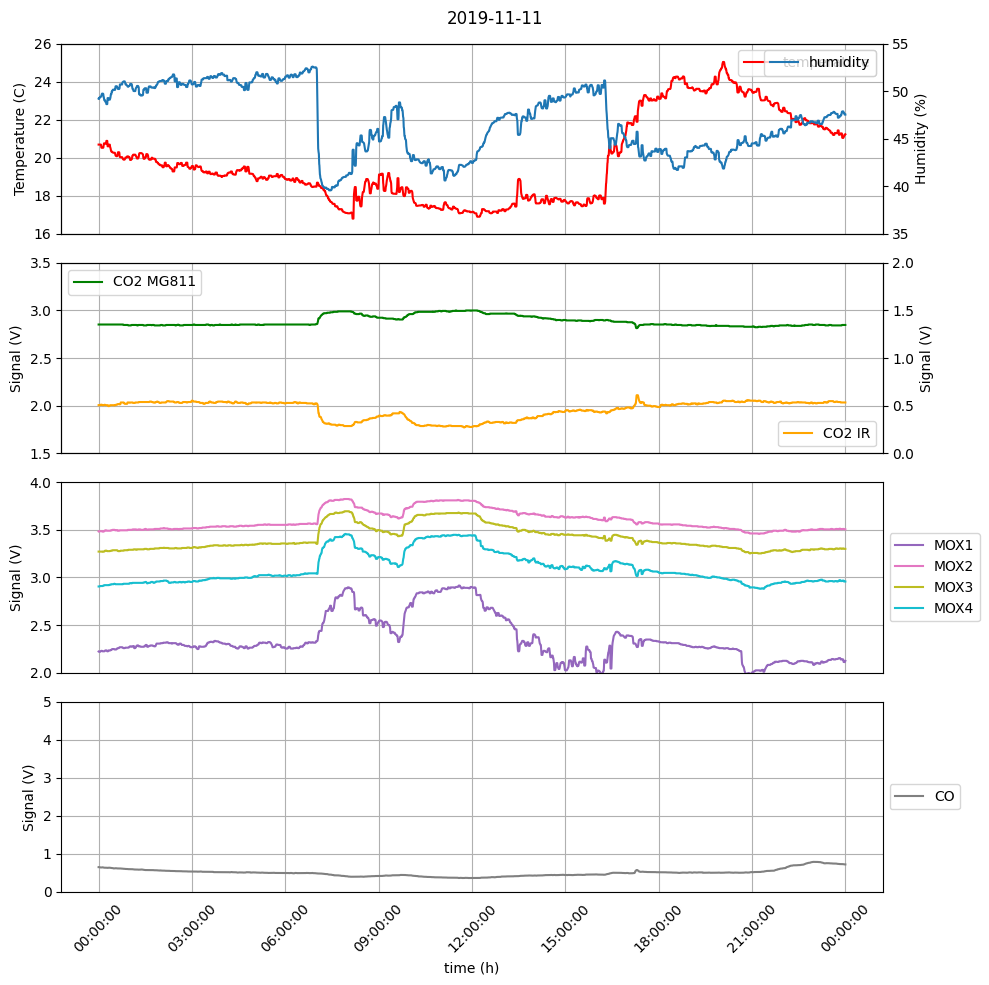

In [9]:
# Create a figure and a grid of subplots
fig, axs = plt.subplots(4, 1, figsize=(10, 10))  # 4 rows, 1 column

# Plot the data in each subplot

axs[0].plot(visual_filtered_df['timestamp'], visual_filtered_df['temperature'], color='red', label='temperature')
axs[0].twin = axs[0].twinx()
axs[0].twin.plot(visual_filtered_df['timestamp'], visual_filtered_df['humidity'], label='humidity')
axs[0].twin.set_ylabel('Humidity (%)')
axs[0].set_ylabel('Temperature (C)')
axs[0].tick_params(axis='both', which='both', bottom=False, top=False, left=True, right=False, labelbottom=False, labelleft=True)
axs[0].twin.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=True, labelbottom=False, labelleft=False)
axs[0].set_ylim(16, 26)
axs[0].twin.set_ylim(35, 55)
axs[0].grid(True)
axs[0].legend()
axs[0].twin.legend()

axs[1].plot(visual_filtered_df['timestamp'], visual_filtered_df['CO2MG811Value'], color='green', label='CO2 MG811')
axs[1].twin = axs[1].twinx()
axs[1].twin.plot(visual_filtered_df['timestamp'], visual_filtered_df['CO2CosIRValue'], color='orange', label='CO2 IR')
axs[1].twin.set_ylabel('Signal (V)')
axs[1].set_ylabel('Signal (V)')
axs[1].tick_params(axis='both', which='both', bottom=False, top=False, left=True, right=False, labelbottom=False, labelleft=True)
axs[1].twin.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=True, labelbottom=False, labelleft=False)
axs[1].grid(True)
axs[1].set_ylim(1.5, 3.5)
axs[1].twin.set_ylim(0, 2)
axs[1].twin.legend(loc='lower right')
axs[1].legend(loc='upper left')

axs[2].plot(visual_filtered_df['timestamp'], visual_filtered_df['MOX1'], color='tab:purple', label='MOX1')
axs[2].plot(visual_filtered_df['timestamp'], visual_filtered_df['MOX2'], color='tab:pink', label='MOX2')
axs[2].plot(visual_filtered_df['timestamp'], visual_filtered_df['MOX3'], color='tab:olive', label='MOX3')
axs[2].plot(visual_filtered_df['timestamp'], visual_filtered_df['MOX4'], color='tab:cyan', label='MOX4')
axs[2].set_ylabel('Signal (V)')
axs[2].tick_params(axis='both', which='both', bottom=False, top=False, left=True, right=False, labelbottom=False, labelleft=True)
axs[2].set_ylim(2, 4)
axs[2].grid(True)
axs[2].legend(loc='center left', bbox_to_anchor=(1, 0.5))

axs[3].plot(visual_filtered_df['timestamp'], visual_filtered_df['COValue'], color='grey', label='CO')
axs[3].set_ylabel('Signal (V)')
axs[3].tick_params(axis='both', which='both', bottom=False, top=False, left=True, right=False, labelbottom=True, labelleft=True)
axs[3].set_ylim(0, 5)
axs[3].grid(True)
axs[3].set_xlabel('time (h)')    
axs[3].legend(loc='center left', bbox_to_anchor=(1, 0.5))
date_format = DateFormatter('%H:%M:%S')
axs[3].xaxis.set_major_formatter(date_format)    
axs[3].tick_params(axis='x', labelrotation=45)

# Adjust layout
fig.suptitle('2019-11-11')
plt.tight_layout()

# Show the plots
plt.show()

## PCA fit on no occupant data

There are two operations other than the plain ```PCA``` implemented in Pyspark ML-lib that are necessary to build the pipeline:
1. **Standardization of the input data**

This is done through the `StandardScaler` implemented in Pyspark ML-lib.
The input data are standardized in order to 
- be compliant with the PCA assumption of having the features centered on zero  
- have the same influence of each features on the new space obtained by the PCA

Taking $\mu$ as the matrix having in each row the means of all the features and $\sigma$ as the matrix having in each column the standard deviations of all the features, $X$ being the original data we define the normalized data $X_{normalized}$ as:

$$X_{normalized} = \frac{X - \mu}{\sigma}$$

2. **Inverting the PCA projection**

To invert the transformation that is projecting the original data onto the new space 

$$ X_{proj} = X_{normalized} \cdot K$$

where $K$ is the principal component matrix obtained through PCA and $X_{proj}$ is the projection of $X_{normalized}$ on the   space defined by the principal components, we compute

$$X_{reconstructed} = (X_{proj} \cdot K^{-1}) \cdot \sigma + \mu = (X_{proj} \cdot K^{T}) \cdot \sigma + \mu$$

Naturally, if $K$, is not a square matrix (output space has same dimension of input space), the reconstruction will be lossy.

In [10]:
# pca fit
n_components = 9

# grouping features in an unique input column
assembler = VectorAssembler(inputCols = cols_to_process, outputCol = 'features')
assembled_df_no_occupants = assembler.transform(no_occupants_filtered_df)

# standardize data
scaler = StandardScaler(inputCol="features", outputCol="scaled_features_centered", withStd=True, withMean=True)
scaler = scaler.fit(assembled_df_no_occupants)
assembled_df_no_occupants = scaler.transform(assembled_df_no_occupants) \
                            .drop("features") \
                            .withColumnRenamed("scaled_features_centered", "features")

# Define PCA model
pca = PCA(k=n_components, inputCol="features", outputCol="pcaFeatures")

# Fit the model to the data
pca = pca.fit(assembled_df_no_occupants)

# Transform the data
pca_no_occupants = pca.transform(assembled_df_no_occupants).orderBy('timestamp')

var_proj = pca.explainedVariance

print('Variance explained by each dimension:\n', 
      *[f'PCA component {i+1}: {round(var_proj[i]*100,2)} % \n' for i in range (len(var_proj))])

24/06/07 08:04:57 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


Variance explained by each dimension:
 PCA component 1: 76.49 % 
 PCA component 2: 10.77 % 
 PCA component 3: 5.68 % 
 PCA component 4: 2.42 % 
 PCA component 5: 2.25 % 
 PCA component 6: 1.46 % 
 PCA component 7: 0.78 % 
 PCA component 8: 0.12 % 
 PCA component 9: 0.03 % 



24/06/07 08:04:58 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


## PCA inference

### No occupant data - before environmental correction

In [11]:
pca_no_occupants_ = pca_no_occupants.withColumn("hour", hour(pca_no_occupants.timestamp)) \
                                    .where("timestamp >= '2020-01-27' AND timestamp < '2020-02-02'") \
                                    .where("hour=0 OR hour=4 OR hour=8 OR hour=12 OR hour=16 OR hour=20")

df_visual = pca_no_occupants_.select(['timestamp','pcaFeatures']).toPandas()
visual_data = np.array(df_visual['pcaFeatures'].tolist())

In [12]:
#visual_data = pca_no_occupants_[visual_days]
visual_data_days_df = pd.DataFrame({'PC1':visual_data[:,1], 'PC2':visual_data[:,0], 'day':pd.to_datetime(df_visual['timestamp']).dt.date})
visual_data_hours_df = pd.DataFrame({'PC1':visual_data[:,1], 'PC2':visual_data[:,0], 'hour':pd.to_datetime(df_visual['timestamp']).dt.hour.astype('str')})

## Plot no occupant data before environmental correction by hour
x_min, x_max = visual_data_hours_df['PC1'].min()*1.05, visual_data_hours_df['PC1'].max()*1.05
y_min, y_max = visual_data_hours_df['PC2'].min()*1.05, visual_data_hours_df['PC2'].max()*1.05

fig = px.scatter(visual_data_hours_df, x='PC1', y='PC2', color='hour', opacity=0.5, color_discrete_sequence= px.colors.sequential.Plasma_r)
fig.update_traces(marker=dict(colorscale='Viridis'), selector=dict(type='scatter'))
fig.update_layout(
    xaxis_title="PC1 ({:.2f} %)".format(var_proj[0]*100),
    yaxis_title="PC2 ({:.2f} %)".format(var_proj[1]*100),
    xaxis_range=[x_min, x_max],
    yaxis_range=[y_min, y_max]  
)
fig.show()


## Plot no occupant data before environmental correction by day
fig = px.scatter(visual_data_days_df, x='PC1', y='PC2', color='day', opacity=0.5, color_discrete_sequence= px.colors.sequential.Plasma_r)
fig.update_traces(marker=dict(colorscale='Viridis'), selector=dict(type='scatter'))
fig.update_layout(
    xaxis_title="PC1 ({:.2f} %)".format(var_proj[0]*100),
    yaxis_title="PC2 ({:.2f} %)".format(var_proj[1]*100),
    xaxis_range=[x_min, x_max],
    yaxis_range=[y_min, y_max]  
)
fig.show()

PCA space representation of the data set without human activity before environmental correction. Samples colored by time of the day (top) and colored by day (bottom). Due to environmental factors, the samples are ordered by time of the day or by the day of acquisition.

### No occupant data - after environmental correction

- We remove from the projected space $X_{proj}$ the first component by setting

$$X_{proj_{(i,0)}} = 0 \qquad \forall i \in \{ 0, n-1\}$$

$n$ being the number of samples in the dataset.
- We build another PCA just to visually investigate the effect on no occupant data.

In [13]:
# unzipping vectors inside the single column to multiple columns
pca_no_occupants_unzipped = pca_no_occupants.withColumn("feature", vector_to_array("pcaFeatures")).select(["timestamp"]+[col("feature")[i] for i in range(n_components)])

# zero-ing the first component of the pca, to remove it from re-projection in the original space
pca_no_occupants_unzipped = pca_no_occupants_unzipped.withColumn('feature[0]',lit(0))

# re-zipping features into single column
invert_columns_to_convert = pca_no_occupants_unzipped.columns
invert_columns_to_convert.remove('timestamp')
assembler_invert = VectorAssembler(inputCols = invert_columns_to_convert, outputCol = 'pcaFeatures')
pca_no_occupants_zipped = assembler_invert.transform(pca_no_occupants_unzipped).select(['timestamp', 'pcaFeatures']).orderBy('timestamp')

# Define new PCA model
pca_after_corr = PCA(k=3, inputCol="pcaFeatures", outputCol="pcaFeatures2")

# Fit the model to the data
pca_after_corr = pca_after_corr.fit(pca_no_occupants_zipped)
var_new_proj = pca_after_corr.explainedVariance

# Transform the data
pca_no_occupants2 = pca_after_corr.transform(pca_no_occupants_zipped)
pca_no_occupants2_ = pca_no_occupants2.withColumn("hour", hour(pca_no_occupants2.timestamp)) \
                                .where("timestamp >= '2020-01-27' AND timestamp < '2020-02-02'") \
                                .where("hour=0 OR hour=4 OR hour=8 OR hour=12 OR hour=16 OR hour=20")

df_visual2 = pca_no_occupants2_.select(['timestamp','pcaFeatures2']).toPandas()
visual_data_2 = np.array(df_visual2['pcaFeatures2'].tolist())
df_visual.head()

# Plots
    
visual_data_day_df_2 = pd.DataFrame({'PC1':visual_data_2[:,1], 'PC2':visual_data_2[:,0], 'day':pd.to_datetime(df_visual2['timestamp']).dt.date})
visual_data_hours_df_2 = pd.DataFrame({'PC1':visual_data_2[:,1], 'PC2':visual_data_2[:,0], 'hour':pd.to_datetime(df_visual2['timestamp']).dt.hour.astype('str')})

## Plot no occupant data after environmental correction by hour
fig = px.scatter(visual_data_hours_df_2, x='PC1', y='PC2', color='hour', opacity=0.5, color_discrete_sequence= px.colors.sequential.Plasma_r)
fig.update_traces(marker=dict(colorscale='Viridis'), selector=dict(type='scatter'))
fig.update_layout(
    xaxis_title="PC1 ({:.2f} %)".format(var_new_proj[0]*100),
    yaxis_title="PC2 ({:.2f} %)".format(var_new_proj[1]*100),
    xaxis_range=[x_min, x_max],
    yaxis_range=[y_min, y_max] 
)
fig.show()

## Plot no occupant data after environmental correction by day
fig = px.scatter(visual_data_day_df_2, x='PC1', y='PC2', color='day', opacity=0.5, color_discrete_sequence= px.colors.sequential.Plasma_r)
fig.update_traces(marker=dict(colorscale='Viridis'), selector=dict(type='scatter'))
fig.update_layout(
    xaxis_title="PC1 ({:.2f} %)".format(var_new_proj[0]*100),
    yaxis_title="PC2 ({:.2f} %)".format(var_new_proj[1]*100),
    xaxis_range=[x_min, x_max],
    yaxis_range=[y_min, y_max]   
)
fig.show()

PCA space representation of the data set without human activity after environmental correction. Samples colored by time of the day (top) and colored by day (bottom). The samples overlap each other, with a reduced structure on the environmental factors.

### Occupant data - environmental correction

We project the data with occupants in the vector space obtained by PCA on no occupant data, and we remove the first component supposing that it corresponds to noise.

In [14]:
# grouping features in an unique input column
assembled_df_occupants = assembler.transform(occupants_filtered_df).orderBy('timestamp')

# standardize data
occupants_scaler = StandardScaler(inputCol="features", outputCol="scaled_features_centered", withStd=True, withMean=True)
occupants_scaler = occupants_scaler.fit(assembled_df_occupants)
assembled_df_occupants = occupants_scaler.transform(assembled_df_occupants) \
                            .drop("features") \
                            .withColumnRenamed("scaled_features_centered", "features")

# projecting features of occupant data into space generated by no occupant data
pca_occupants = pca.transform(assembled_df_occupants).orderBy('timestamp')

# unzipping vectors inside the single column to multiple columns
pca_occupants_unzipped = pca_occupants.withColumn("feature", vector_to_array("pcaFeatures")).select(['timestamp']+[col("feature")[i] for i in range(n_components)])

# zero-ing the first component of the pca, to remove it from re-projection in the original space
pca_occupants_unzipped = pca_occupants_unzipped.withColumn('feature[0]',lit(0))

# zipping vectors to a single colum
pca_occupants_zipped = assembler_invert.transform(pca_occupants_unzipped).orderBy('timestamp')

# reproject it to original space
K = pca.pc.toArray()
pca_occupants_features = pca_occupants_zipped.toPandas()
X = np.array(pca_occupants_features["pcaFeatures"].tolist())
pca_occupants_features = pca_occupants_features.drop(columns=["pcaFeatures"])
inv_transf_occupants = (X @ K.T)

# inverting normalization
inv_transf_occupants *= occupants_scaler.std 
inv_transf_occupants += np.array(occupants_scaler.mean)

inv_transf_occupants = spark.createDataFrame(pd.concat([pca_occupants_features,pd.DataFrame(inv_transf_occupants, columns=cols_to_process)], axis=1))

In [15]:
# export to csv
inv_transf_occupants_visual = inv_transf_occupants.select(['timestamp']+cols_to_process).orderBy('timestamp').toPandas()
inv_transf_occupants_visual.to_csv("./data/database_gas_after_environmental_correction.csv", sep=',', index=False)

24/06/07 08:08:30 WARN TaskSetManager: Stage 114 contains a task of very large size (27736 KiB). The maximum recommended task size is 1000 KiB.
24/06/07 08:08:31 WARN TaskSetManager: Stage 115 contains a task of very large size (27736 KiB). The maximum recommended task size is 1000 KiB.


#### Event Calculus 

In [16]:
def compute_event(features_matrix):
    event = -1
    
    pca_input = np.array([v.toArray() for v in features_matrix])
    
    if (pca_input.shape[0] == 361):
        pca = SklearnPCA(n_components=2)

        pca.fit(pca_input[:-1, :])
        
        transformed_features = pca.transform(pca_input[:-1, :])
        last_element_pca = pca.transform([pca_input[-1, :]])
        
        means = np.mean(transformed_features, axis=0)
        cov_matrix_sample = np.cov(transformed_features.T)   
        inv_cov_matrix_sample = np.linalg.inv(cov_matrix_sample)

        tmp = last_element_pca - means

        mahalanobis_tsquare_ratio =  (tmp @ inv_cov_matrix_sample @ tmp.T).item()**(-1/2)
        
        event = 1 if mahalanobis_tsquare_ratio > 1 else 0 
    
    return event

In [17]:
from pyspark.sql.functions import hour
from pyspark.sql.functions import date_format, sum, when

if COMPUTE_EVENTS:
    inv_transf_occupants = spark.read.csv("./data/database_gas_after_environmental_correction.csv", header=True, inferSchema=True)
    columns_to_transform = inv_transf_occupants.columns
    columns_to_transform.remove("timestamp")
    
    assembler = VectorAssembler(inputCols=columns_to_transform, outputCol='featuresToWindowPCA')
    assembled_features = assembler.transform(inv_transf_occupants)
    
    window_size = 360
    window_spec = Window.rowsBetween(-window_size, 0).orderBy("timestamp") ## ADD patitioning
    
    compute_event_udf = F.udf(compute_event, IntegerType())
    
    inv_transf_occupants = assembled_features.withColumn("event", compute_event_udf(F.collect_list("featuresToWindowPCA").over(window_spec)))
    
    inv_transf_occupants_pd = inv_transf_occupants.orderBy("timestamp").toPandas()
    inv_transf_occupants_pd.to_csv("./data/database_gas_after_environmental_correction_with_event.csv", sep=',', index=False)
    inv_transf_occupants_pd.iloc[:10,:]
else:
    inv_transf_occupants = spark.read.csv("./data/database_gas_after_environmental_correction_with_event.csv", header=True, inferSchema=True)




In [57]:
from pyspark.sql.functions import hour
from pyspark.sql.functions import date_format, sum, when


inv_transf_occupants = spark.read.csv("./data/database_gas_after_environmental_correction_with_event.csv", header=True, inferSchema=True)#remove
inv_transf_occupants = inv_transf_occupants.withColumn("event", when(inv_transf_occupants["event"] == -1, 0).otherwise(inv_transf_occupants["event"]))

inv_transf_occupants_new = inv_transf_occupants.withColumn("date_hour", date_format(inv_transf_occupants["timestamp"], "yyyy-MM-dd HH"))

event_per_hour = inv_transf_occupants_new.groupBy("date_hour").agg(sum(when(inv_transf_occupants_new["event"] == 1, 1).otherwise(0)).alias("n_event"))

event_per_hour.orderBy("date_hour").toPandas()


,date_hour,n_event
0,2019-11-06 10,0
1,2019-11-06 11,0
2,2019-11-06 12,18
3,2019-11-06 13,10
4,2019-11-06 14,47
...,...,...
1892,2020-01-24 19,89
1893,2020-01-24 20,0
1894,2020-01-24 21,130
1895,2020-01-24 22,60


In [64]:

event_per_hour_christmas = event_per_hour.where("date_hour = '2019-11-06 20'")
event_per_hour_christmas = event_per_hour_christmas.orderBy('date_hour')
event_per_hour_christmas.show()
event_per_hour.show()

+-------------+-------+
|    date_hour|n_event|
+-------------+-------+
|2019-11-06 20|      4|
+-------------+-------+

+-------------+-------+
|    date_hour|n_event|
+-------------+-------+
|2019-11-06 20|      4|
|2019-12-11 19|     78|
|2019-12-15 03|     14|
|2019-11-08 15|    113|
|2019-11-10 05|     43|
|2019-11-12 21|     30|
|2019-11-13 00|      0|
|2019-11-23 10|    147|
|2019-11-30 01|      0|
|2019-12-15 15|     59|
|2019-12-15 22|      1|
|2019-11-30 10|     93|
|2019-12-10 23|     36|
|2019-11-07 20|     62|
|2019-11-13 22|      2|
|2019-11-20 02|      0|
|2019-11-22 23|      7|
|2019-12-07 10|     40|
|2019-12-13 05|     33|
|2019-11-12 13|     55|
+-------------+-------+
only showing top 20 rows



#### Sensors signals after environmental correction (plot)

/tmp/ipykernel_1880/2876554370.py:66: UserWarning:                              

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



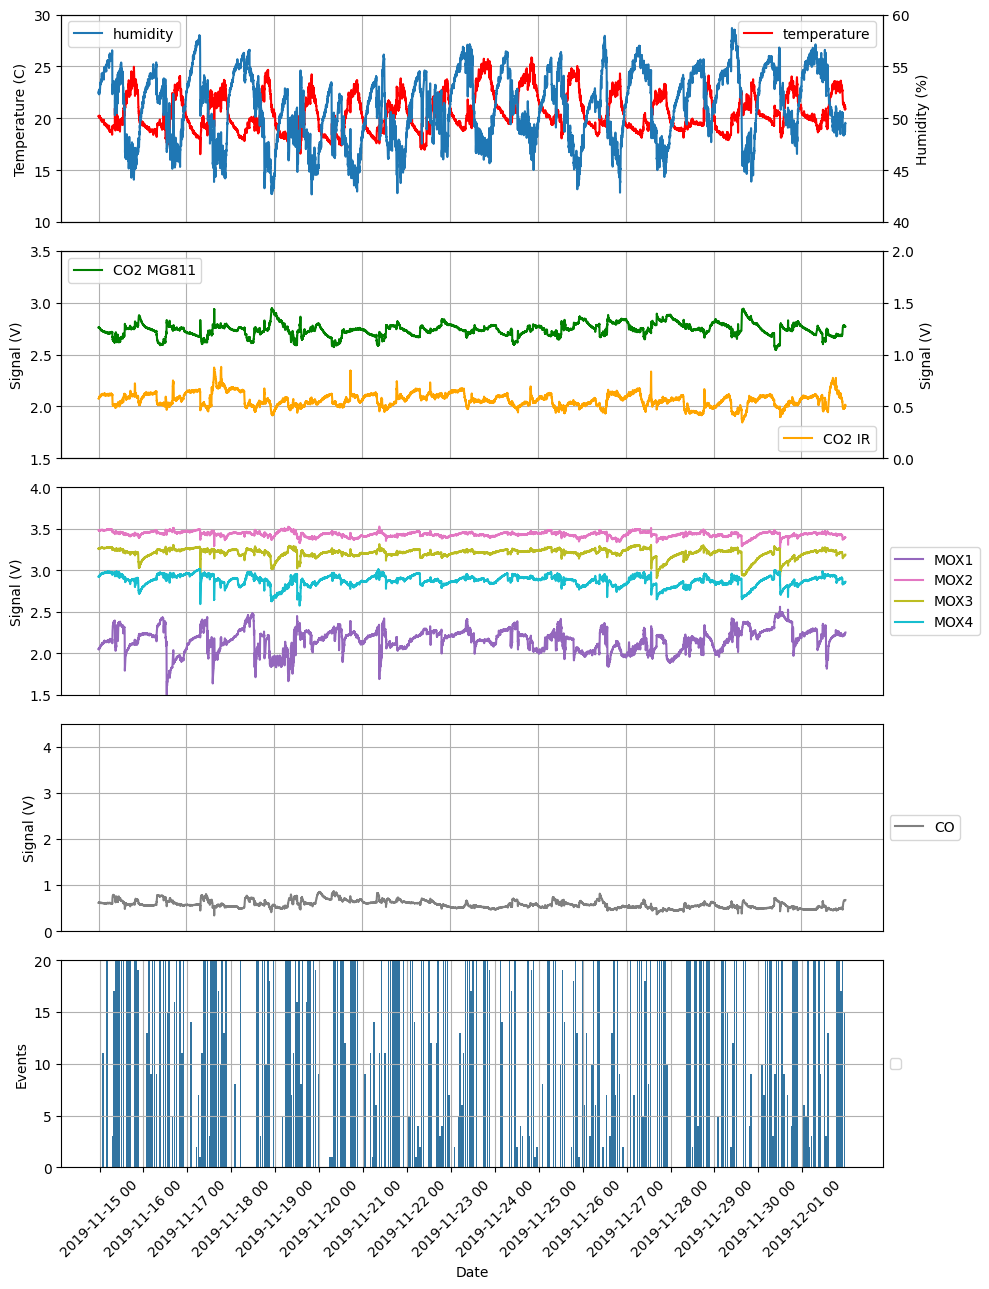

In [19]:
# selecting time interval of interest

visual_filtered_df = inv_transf_occupants.where("timestamp >= '2019-11-15' AND timestamp <= '2019-12-02' ")
event_per_hour_1 = event_per_hour.where("date_hour >= '2019-11-15' AND date_hour <= '2019-12-02' ")

visual_filtered_df = visual_filtered_df.select([col(c) for c in columns_to_keep] + [F.round(col(c), 4).alias(c) for c in columns_to_normalize])

visual_filtered_df = visual_filtered_df.orderBy('timestamp').toPandas()
event_per_hour_pd = event_per_hour_1.orderBy('date_hour').toPandas()


# Create a figure and a grid of subplots
fig, axs = plt.subplots(5, 1, figsize=(10, 13))  # 4 rows, 1 column

# Plot the data in each subplot

axs[0].plot(visual_filtered_df['timestamp'], visual_filtered_df['temperature'], color='red', label='temperature')
axs[0].twin = axs[0].twinx()
axs[0].twin.plot(visual_filtered_df['timestamp'], visual_filtered_df['humidity'], label='humidity')
axs[0].twin.set_ylabel('Humidity (%)')
axs[0].set_ylabel('Temperature (C)')
axs[0].tick_params(axis='both', which='both', bottom=False, top=False, left=True, right=False, labelbottom=False, labelleft=True)
axs[0].twin.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=True, labelbottom=False, labelleft=False)
axs[0].set_ylim(10, 30)
axs[0].twin.set_ylim(40, 60)
axs[0].grid(True)
axs[0].legend()
axs[0].twin.legend()


axs[1].plot(visual_filtered_df['timestamp'], visual_filtered_df['CO2MG811Value'], color='green', label='CO2 MG811')
axs[1].twin = axs[1].twinx()
axs[1].twin.plot(visual_filtered_df['timestamp'], visual_filtered_df['CO2CosIRValue'], color='orange', label='CO2 IR')
axs[1].twin.set_ylabel('Signal (V)')
axs[1].set_ylabel('Signal (V)')
axs[1].tick_params(axis='both', which='both', bottom=False, top=False, left=True, right=False, labelbottom=False, labelleft=True)
axs[1].twin.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=True, labelbottom=False, labelleft=False)
axs[1].grid(True)
axs[1].set_ylim(1.5, 3.5)
axs[1].twin.set_ylim(0, 2)
axs[1].twin.legend(loc='lower right')
axs[1].legend(loc='upper left')


axs[2].plot(visual_filtered_df['timestamp'], visual_filtered_df['MOX1'], color='tab:purple', label='MOX1')
axs[2].plot(visual_filtered_df['timestamp'], visual_filtered_df['MOX2'], color='tab:pink', label='MOX2')
axs[2].plot(visual_filtered_df['timestamp'], visual_filtered_df['MOX3'], color='tab:olive', label='MOX3')
axs[2].plot(visual_filtered_df['timestamp'], visual_filtered_df['MOX4'], color='tab:cyan', label='MOX4')
axs[2].set_ylabel('Signal (V)')
axs[2].tick_params(axis='both', which='both', bottom=False, top=False, left=True, right=False, labelbottom=False, labelleft=True)
axs[2].set_ylim(1.5, 4)
axs[2].grid(True)
axs[2].legend(loc='center left', bbox_to_anchor=(1, 0.5))


axs[3].plot(visual_filtered_df['timestamp'], visual_filtered_df['COValue'], color='grey', label='CO')
axs[3].set_ylabel('Signal (V)')
axs[3].tick_params(axis='both', which='both', bottom=False, top=False, left=True, right=False, labelbottom=False, labelleft=True)
axs[3].set_ylim(0, 4.5)
axs[3].grid(True)   
axs[3].legend(loc='center left', bbox_to_anchor=(1, 0.5))


event_per_hour_pd['date_hour'] = event_per_hour_pd['date_hour'].astype(str)
sns.barplot(ax=axs[4], x='date_hour', y='n_event', data=event_per_hour_pd, errorbar='sd') 
axs[4].legend(loc='center left', bbox_to_anchor=(1, 0.5))
axs[4].set_ylabel('Events')
axs[4].grid(True)
axs[4].set_ylim(0, 20)
date_format = DateFormatter('%Y-%m-%d')
axs[4].tick_params(axis='both', which='both', bottom=True, top=False, left=True, right=False, labelbottom=True, labelleft=True)
axs[4].xaxis.set_major_formatter(date_format)    
axs[4].tick_params(axis='x', labelrotation=45)
axs[4].set_xlabel('Date') 

# Adjust x_labels
num_labels = 17 
labels = event_per_hour_pd['date_hour']
step = max(1, len(labels) // num_labels)
axs[4].set_xticks(range(0, len(labels), step))
axs[4].set_xticklabels(labels[::step], rotation=45)

# Adjust margin
x_min, x_max = axs[4].get_xlim()
margin = 0.05 * (x_max - x_min)
axs[4].set_xlim(x_min - margin, x_max + margin)


# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

<Axes: xlabel='hour', ylabel='date'>

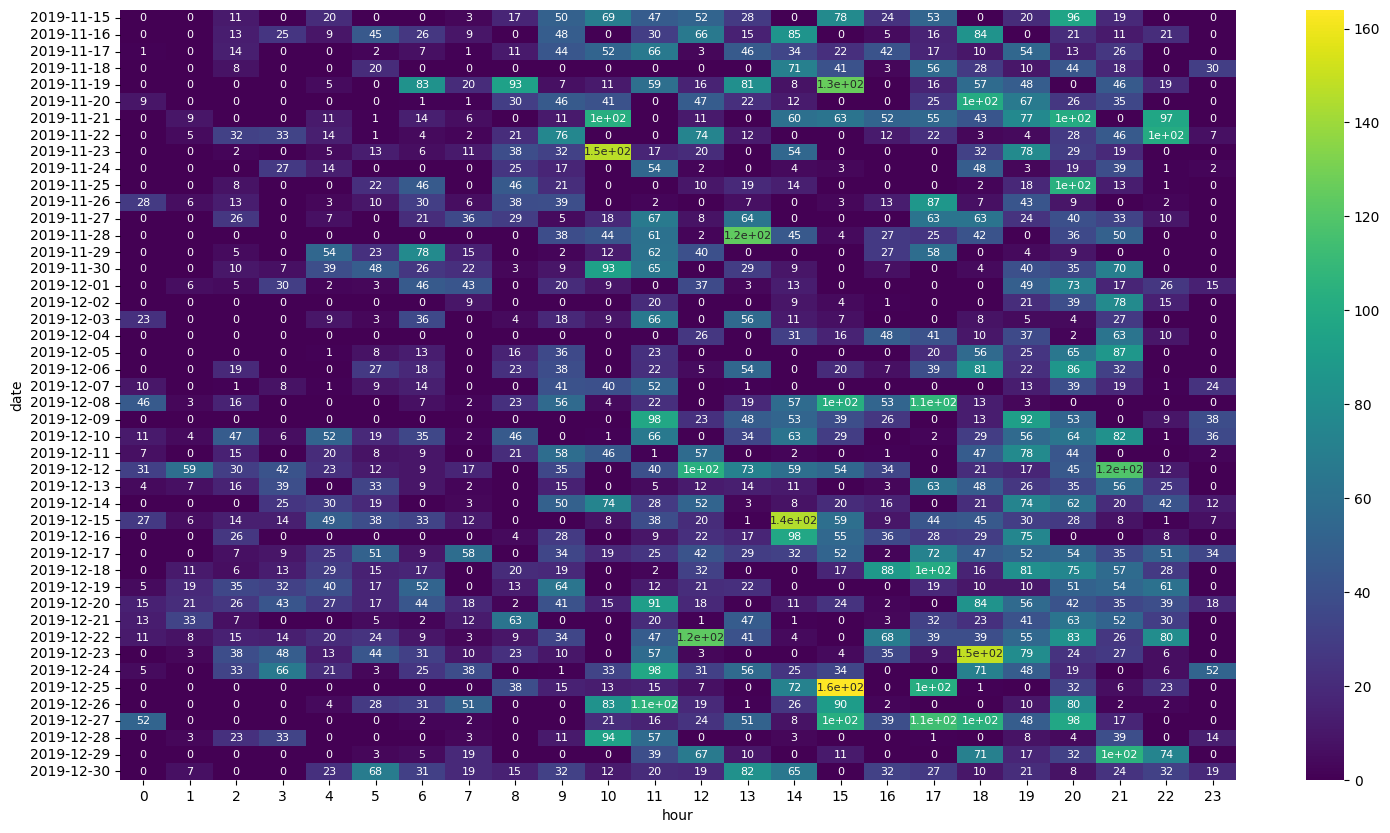

In [20]:
from pyspark.sql.functions import hour
from pyspark.sql.functions import date_format, sum, when
event_per_hour_2 = event_per_hour.where("date_hour >= '2019-11-15' AND date_hour <= '2019-12-31' ")

event_per_hour_2 = event_per_hour_2.withColumn("date", date_format(event_per_hour_2["date_hour"], "yyyy-MM-dd"))
event_per_hour_2 = event_per_hour_2.withColumn("hour", hour(event_per_hour_2["date_hour"]))

pivot_df = event_per_hour_2.toPandas().fillna(0).pivot(index='date', columns='hour', values='n_event')
pivot_df = pivot_df.fillna(0)

# Crea la heatmap
plt.figure(figsize=(18, 10))
sns.heatmap(pivot_df, cmap='viridis', annot=True, annot_kws={'size': 8})

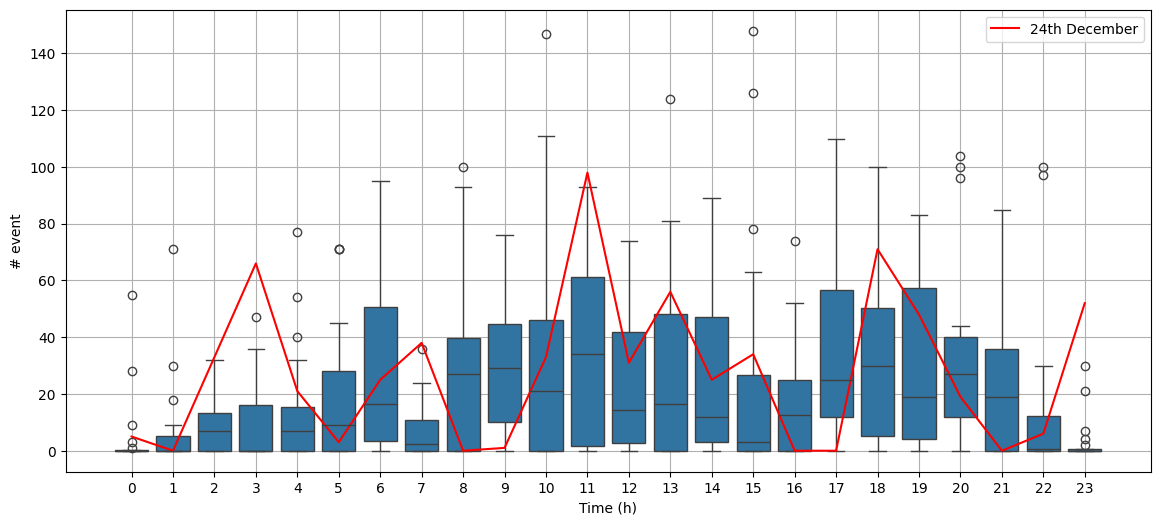

In [84]:
event_per_hour_nov = event_per_hour.where("date_hour >= '2019-11-1' AND date_hour <= '2019-11-30' ")
event_per_hour_nov = event_per_hour_nov.orderBy('date_hour')

event_per_hour_christmas = event_per_hour.where("date_hour >= '2019-12-24' AND date_hour < '2019-12-25' ")
event_per_hour_christmas = event_per_hour_christmas.orderBy('date_hour')
#event_per_hour_christmas.show(event_per_hour_christmas.count(), truncate=False)


event_per_hour_nov = event_per_hour_nov.withColumn("date", date_format(event_per_hour_nov["date_hour"], "yyyy-MM-dd"))
event_per_hour_nov = event_per_hour_nov.withColumn("hour", hour(event_per_hour_nov["date_hour"]))

event_per_hour_christmas = event_per_hour_christmas.withColumn("date", date_format(event_per_hour_christmas["date_hour"], "yyyy-MM-dd"))
event_per_hour_christmas = event_per_hour_christmas.withColumn("hour", hour(event_per_hour_christmas["date_hour"]))


pivot_nov_df = event_per_hour_nov.toPandas().fillna(0).pivot(index='date', columns='hour', values='n_event')
pivot_nov_df = pivot_df.fillna(0)
df_nov_melted =  pd.melt(pivot_df, var_name='Time (h)', value_name='# event')

pivot_christmas_df = event_per_hour_christmas.toPandas().fillna(0).pivot(index='date', columns='hour', values='n_event')
pivot_christmas_df = pivot_christmas_df.fillna(0)
df_christmas_melted =  pd.melt(pivot_christmas_df, var_name='Time (h)', value_name='# event')


plt.figure(figsize=(14, 6))
sns.boxplot(x='Time (h)', y='# event', data=df_nov_melted)
plt.plot( event_per_hour_christmas.toPandas()['n_event'], color='red', label='24th December')
plt.legend()
plt.grid()
plt.show()
